<a href="https://colab.research.google.com/github/10100111/Display-of-HW1/blob/main/53_Lite_%D0%9A%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F_%D0%9A%D0%BE%D1%80%D0%B7%D0%B8%D0%BD%D1%8B_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задание Lite

Используйте готовый ноутбук с кластеризацией базы покупок интернет-магазина.

Удалите из выборки все строки про доставку.

Выведите две гистограммы:

Распределения размеров кластеров: сколько корзин

Распределение количества уникальных позиций в кластере

Напишите продвинутую функцию визуализации одного выбранного кластера:

Размер кластера

Количество уникальных позиций

Позиции, которые есть минимум в 20% корзин

Уникальные слова в описаниях позиций, которые встречаются минимум в 20% 
позиций, для отслеживания монобрендовых и монотоварных закупок
 

# Библиотеки

In [ ]:
# графики отображаются в той ячейке, в которой введен plt.show()
%matplotlib inline 

import pandas as pd
import numpy as np
import time 

import matplotlib.pyplot as plt
from tensorflow.keras import utils # для получения OHE представления
from keras.preprocessing.text import Tokenizer, text_to_word_sequence, tokenizer_from_json

from sklearn.preprocessing import StandardScaler, LabelEncoder # импортируем библиотеку StandardScaler и LabelEncoder
from sklearn.cluster import KMeans # импортируем библиотеку KMeans для кластеризации

# Загружаем базу

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Базы/online_carts.csv') # читаем данные из загруженной базы

In [ ]:
df.head()

,Unnamed: 0,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,NaN,Период: Февраль 2019 г. - Август 2019 г.,NaN,NaN,NaN
1,NaN,Показатели: Стоимость продажи (руб.)(С НДС),Количество(Базовых ед.),NaN,NaN
2,NaN,Группировки строк: ЗаказПокупателя.Дата оправк...,ЗаказПокупателя.ID заказа (Элементы),Номенклатура.Наименование (Элементы),NaN
3,NaN,Отборы:\nПодразделение В списке (estel.m-cosme...,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Выведем уникальные значения каждого из безымянных столбцов
print(df['Unnamed: 0'].unique(),
      df['Unnamed: 2'].unique(),
      df['Unnamed: 3'].unique(), sep='\n')

[nan]
[nan ' Количество(Базовых ед.)' ' ЗаказПокупателя.ID заказа (Элементы)'
 ... '3472' '7616' '2731']
[nan ' Номенклатура.Наименование (Элементы)' 'Количество' 'Базовых ед.'
 '9' '1' '4' '797' '162' '3' '2' '5' '7' '8' '6' '49' '10' '34' '11' '25'
 '20' '13' '17' '29' '1130' '148' '12' '40' '14' '50' '68' '51' '23' '22'
 '16' '1096' '105' '124' '139' '19' '15' '26' '30' '21' '504' '28' '575'
 '60' '61' '18' '80' '942' '44' '188' '24' '1375' '147' '137' '33' '597'
 '82' '37' '860' '47' '825' '27' '45' '229' '887' '113' '58' '104' '38'
 '1751' '134' '138' '1214' '341' '168' '81' '88' '1074' '150' '32' '52'
 '43' '1023' '64' '72' '31' '39' '1237' '254' '46' '289' '1938' '456'
 '132' '2689' '599' '1771' '181' '322' '77' '556' '90' '256' '42' '57'
 '35' '883' '118' '1078' '145' '2749' '36' '1360' '85' '893' '214' '692'
 '119' '1533' '239' '650' '93' '70' '1551' '158' '78' '102' '780' '291'
 '41' '1278' '140' '48' '161' '1127' '122' '94' '978' '98' '769' '92'
 '159' '720' '69' '56' '1648'

In [ ]:
new = df.drop(['Unnamed: 0'], axis=1) # удаляем бесполезный столбец, не несет инфо
new.insert(0, column='Дата', value = [x for x in range(len(new))]) # вставим новую колонку "Дата", чтобы из базы вытащить данные о времени в отдельную колонку
new = new.fillna('unknown') 
new.head(30)

,Дата,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,0,Период: Февраль 2019 г. - Август 2019 г.,unknown,unknown,unknown
1,1,Показатели: Стоимость продажи (руб.)(С НДС),Количество(Базовых ед.),unknown,unknown
2,2,Группировки строк: ЗаказПокупателя.Дата оправк...,ЗаказПокупателя.ID заказа (Элементы),Номенклатура.Наименование (Элементы),unknown
3,3,Отборы:\nПодразделение В списке (estel.m-cosme...,unknown,unknown,unknown
4,4,unknown,unknown,unknown,unknown
5,5,ЗаказПокупателя.Дата оправки,Стоимость продажи (руб.),Количество,unknown
6,6,ЗаказПокупателя.ID заказа,С НДС,Базовых ед.,unknown
7,7,Номенклатура.Наименование,unknown,unknown,unknown
8,8,unknown,unknown,unknown,unknown
9,9,01.01.2019 0:00:00,26236,9,unknown


In [ ]:
new[new['Валовая прибыль'].str.contains('MCOSM')] # MCOSM - флаг начала корзины

,Дата,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4
10,10,MCOSM13113,26236,9,unknown
22,22,MCOSM13113,1929,4,unknown
166,166,MCOSM4885,350,2,unknown
168,168,MCOSM4996,9436,4,unknown
172,172,MCOSM5963,8625,6,unknown
...,...,...,...,...,...
99589,99589,MCOSM33527,2714,6,unknown
99596,99596,MCOSM33529,3145,9,unknown
99603,99603,MCOSM33530,3030,12,unknown
99616,99616,MCOSM33537,2259,2,unknown


In [ ]:
# Собираем в единый списое все индексы строк в которых есть инфо в виде даты
date_list = list(new[new['Валовая прибыль'].str.contains("\d\d.\d\d.2019")].index)

indx = 0
for i in range(len(new)):                       # проходимся по каждой строке базы
  if i in date_list:                            # если индекс содержится в строках, где есть дата
    indx = i                                    # обновляем текущий индекс
  new['Дата'][i] = new['Валовая прибыль'][indx] # присваиваем текущий индекс всем последующим строкам, пока не наткнемся на следующую дату

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
new

,Дата,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,Период: Февраль 2019 г. - Август 2019 г.,Период: Февраль 2019 г. - Август 2019 г.,unknown,unknown,unknown
1,Период: Февраль 2019 г. - Август 2019 г.,Показатели: Стоимость продажи (руб.)(С НДС),Количество(Базовых ед.),unknown,unknown
2,Период: Февраль 2019 г. - Август 2019 г.,Группировки строк: ЗаказПокупателя.Дата оправк...,ЗаказПокупателя.ID заказа (Элементы),Номенклатура.Наименование (Элементы),unknown
3,Период: Февраль 2019 г. - Август 2019 г.,Отборы:\nПодразделение В списке (estel.m-cosme...,unknown,unknown,unknown
4,Период: Февраль 2019 г. - Август 2019 г.,unknown,unknown,unknown,unknown
...,...,...,...,...,...
99627,02.09.2019 0:00:00,Kapous Блеск-шампунь Brilliants gloss 250 мл,347,1,unknown
99628,02.09.2019 0:00:00,Крем-бальзам-архитектор волос для восстановле...,345,1,unknown
99629,02.09.2019 0:00:00,Услуга доставки DPD до двери,350,1,unknown
99630,02.09.2019 0:00:00,Шампунь разглаживающий с глиоксиловой кислот...,304,1,unknown


In [ ]:
new = new.drop(new[new['Дата'].str.contains('Период')].index, axis = 0)            # выкинем превьюшные строки
# new = new.drop(new[new['Валовая прибыль'].str.contains('Услуга доставки')].index, axis = 0)            # выкинем строки, в которых есть доставка
new = new.drop(new[new['Валовая прибыль'].str.contains('unknown')].index, axis=0)  # выкинем пустые строки
new = new.drop(new[new['Валовая прибыль']==new['Дата']].index)                     # выкинем строки даты, которые находятся в столбце корзин
new.reset_index(inplace=True)                                                      # обновим индекс
new = new.drop('index', axis=1)                                                    # выкинем ненужную колонку, после предыдущей операции

In [ ]:
new = new.drop(new[new['Валовая прибыль'].str.contains('Услуга доставки')].index, axis = 0)   # выкинем строки, в которых есть доставка

In [ ]:
new # проверили, что все строки с "доставкой" удалены

,Дата,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,01.01.2019 0:00:00,MCOSM13113,26236,9,unknown
1,01.01.2019 0:00:00,CONTURA (HS61) машинка для стрижки волос,9059,1,unknown
2,01.01.2019 0:00:00,Holika Holika Универсальный гель 99% алоэ вера...,539,1,unknown
3,01.01.2019 0:00:00,Kapous Бальзам-уход для придания объема Volume...,181,1,unknown
4,01.01.2019 0:00:00,Kapous Шампунь для придания объема Volume up 3...,181,1,unknown
...,...,...,...,...,...
99178,02.09.2019 0:00:00,MCOSM32997,1691,5,unknown
99179,02.09.2019 0:00:00,Kapous Блеск-шампунь Brilliants gloss 250 мл,347,1,unknown
99180,02.09.2019 0:00:00,Крем-бальзам-архитектор волос для восстановле...,345,1,unknown
99182,02.09.2019 0:00:00,Шампунь разглаживающий с глиоксиловой кислот...,304,1,unknown


In [ ]:
new = new.replace('!"#$%&()\*+,-–—./…:;<=>?@^_`{|}~«»\t\n\xa0\'','', regex=True)

In [ ]:
new.reset_index(inplace=True)                                                      # обновим индекс
new = new.drop('index', axis=1) 

In [ ]:
new

,Дата,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,01.01.2019 0:00:00,MCOSM13113,26236,9,unknown
1,01.01.2019 0:00:00,CONTURA (HS61) машинка для стрижки волос,9059,1,unknown
2,01.01.2019 0:00:00,Holika Holika Универсальный гель 99% алоэ вера...,539,1,unknown
3,01.01.2019 0:00:00,Kapous Бальзам-уход для придания объема Volume...,181,1,unknown
4,01.01.2019 0:00:00,Kapous Шампунь для придания объема Volume up 3...,181,1,unknown
...,...,...,...,...,...
90278,02.09.2019 0:00:00,MCOSM32997,1691,5,unknown
90279,02.09.2019 0:00:00,Kapous Блеск-шампунь Brilliants gloss 250 мл,347,1,unknown
90280,02.09.2019 0:00:00,Крем-бальзам-архитектор волос для восстановле...,345,1,unknown
90281,02.09.2019 0:00:00,Шампунь разглаживающий с глиоксиловой кислот...,304,1,unknown


In [ ]:
cart_list = list(new[new['Валовая прибыль'].str.contains('MCOSM')].index) # Список индексов строк, в которых лежит флаг корзины
cafre_list = list(new[new['Валовая прибыль'].str.contains('CAFRE')].index)# Список индексов строк, в которых лежит флаг 'CAFRE'

In [ ]:
# Глянем на распаршеную базу
new.head()

,Дата,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,01.01.2019 0:00:00,MCOSM13113,26236,9,unknown
1,01.01.2019 0:00:00,CONTURA (HS61) машинка для стрижки волос,9059,1,unknown
2,01.01.2019 0:00:00,Holika Holika Универсальный гель 99% алоэ вера...,539,1,unknown
3,01.01.2019 0:00:00,Kapous Бальзам-уход для придания объема Volume...,181,1,unknown
4,01.01.2019 0:00:00,Kapous Шампунь для придания объема Volume up 3...,181,1,unknown


In [ ]:
carts = []                     # Здесь будут лежать все корзины 
cart=[]                        # В этом списке будет текущая корзина
i=0                            # Счетчик для прохождения по базе
val = new['Валовая прибыль']   # Будем работать с этим столбцом
allPositions = []              # Создаем пустой список позиций

while i!=len(new):             # Пока не дойдем до конца списка
  if i in cart_list:           # Если счетчик в списке индексов-корзин
    if i!=cart_list[-1]:       # Проверяем, если это не последний индекс-флаг
      ind = cart_list.index(i) # Текущему индексу-флагу присваиваем значение конкретно этой корзины

      # Если корзина пустая (после удаления услуг)
      if (i==cart_list[ind+1]-1):
        i+=1 

      # Пробегаемся дальше по счетчику до момента, когда он не будет равен следующему в списке индексу-флагу
      # Если условия соблюдаются, то закидываем следующую строку в текущую корзину
      # Инкремент счетчика
      while i<cart_list[ind+1]-1:
        cart.append(val[i+1])
        allPositions.append(val[i+1]) 
        i+=1 
      
    else: # Если же текущий индекс-флаг последний в списке, пробегаемся дальше по счетчику
          # До момента, когда он не будет равен концу списка всех строк в столбце-1
          # Если условия соблюдаются, то закидываем следующую строку в текущую корзину
      while i<(len(new)-1):
        cart.append(val[i+1])
        allPositions.append(val[i+1]) 
        i+=1

    carts.append(cart)         # Закидываем корзину в список всех корзин
    cart=[]                    # Очищаем корзину
    
  else:
    i+=1                       # Если счетчик не в списке корзин, то инкрементируем

In [ ]:
# Проверка , если у нас количество корзин совпадает с количеством флагов-корзин
print(len(carts)==len(cart_list))
print('Количество всех позиций: ', len(allPositions))
print('Пример того, что лежит в корзине: ', carts[0])

True
Количество всех позиций:  76716
Пример того, что лежит в корзине:  ['CONTURA (HS61) машинка для стрижки волос', 'Holika Holika Универсальный гель 99% алоэ вера, 250 мл', 'Kapous Бальзам-уход для придания объема Volume up 350 мл', 'Kapous Шампунь для придания объема Volume up 350 мл', 'XPERT (HS71) машинка для стрижки волос', 'ЛП ТНА САВАЖ ПАНАШ 250 мл', 'перчатки (50 пар) винил размер S черные']


In [ ]:
for i in range(10):
  print(carts[i])

['CONTURA (HS61) машинка для стрижки волос', 'Holika Holika Универсальный гель 99% алоэ вера, 250 мл', 'Kapous Бальзам-уход для придания объема Volume up 350 мл', 'Kapous Шампунь для придания объема Volume up 350 мл', 'XPERT (HS71) машинка для стрижки волос', 'ЛП ТНА САВАЖ ПАНАШ 250 мл', 'перчатки (50 пар) винил размер S черные']
['OLLIN SERVICE LINE Увлаж. Бальзам для волос 1000 мл', 'OLLIN SERVICE LINE Шампунь.-стабилизатор рН 3.5 1000 мл', 'Масло-уход для светлых волос  ESTEL PRIMA BLONDE 100 мл.', '/101 Крем-краска ESTEL PRINCESS ESSEX пепельный', '/44 Крем-краска ESTEL PRINCESS ESSEX медный', '0/00 Стойкая крем-краска чистый тон', '0/00N Крем-краска ESTEL PRINCESS ESSEX нейтральный', '0/11 Крем-краска ESTEL PRINCESS ESSEX синий', '0/22 Крем-краска ESTEL PRINCESS ESSEX зеленый', '0/33 Крем-краска ESTEL PRINCESS ESSEX желтый', '0/33 Стойкая крем-краска интенсивный золотистисты', '0/55 Крем-краска ESTEL PRINCESS ESSEX красный', '0/66 Крем-краска ESTEL PRINCESS ESSEX фиолетовый', '1/0

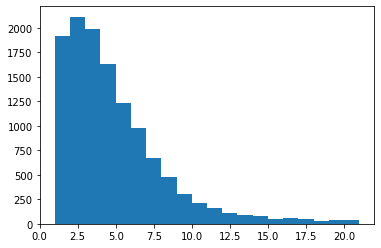

In [ ]:
# Отобразим гистограмму корзин
plt.hist([len(c) for c in carts], 20, [1, 21])
plt.show()

In [ ]:
labelEncoder = LabelEncoder() # создаем объект LabelEncoder
labelEncoder.fit(allPositions) # обрабатываем все имеющиеся позиции товаров

LabelEncoder()

In [ ]:
# Посчитаем кол-во уникальных товаров и отобразим
maxPositionsCount = max(labelEncoder.transform(allPositions))+1
print(maxPositionsCount)

6658


In [ ]:
# Создаем список индексов для каждой корзины
cartsIndexes = [labelEncoder.transform(c) for c in carts]

In [ ]:
n = 5                      # укажем номер корзины
print(carts[n])            # отобразим содержимое этой корзины 
print(cartsIndexes[n])     # отобразим соответствующие индексы

['10/65 светлый блондин фиолетово-красный DLSe', '10/76 светлый блондин коричнево-фиолетовый DLSe', 'Бальзам DE LUXE для выравнивания структуры 1000 мл.', 'Бальзам DE LUXE стабилизатор цвета 1000 мл.', 'Восстанавливающий эликсир LuxeOil 100 мл.', 'Разглаживающее масло для интенсивного блеска 100 мл. Wella', 'Шампунь DE LUXE интенсивное очищение 1000 мл.', 'Шампунь DE LUXE стабилизатор цвета 1000 мл.']
[ 211  239 3092 3093 3323 5181 5737 5738]


In [ ]:
'''
Функция преобразования вектора по принципу bag of words
  Входные параметры:
    -trainVector - исходный вектор индексов слов
    -wordsCount - установленная длина вектора

'''
def changeXTo01(trainVector, wordsCount):  
  out = np.zeros(wordsCount)               # создаем вектор из нулей длиной wordsCount
  for x in trainVector:                    # пробегаем по всем индексам trainVector
    out[x] = 1                             # изменяем на 1 значение out в позиции текущего мндекса
  return out                               # возвращаем сформированный вектор


'''
Функция преобразования обучающей и проверочной выборки по принципу bag of words
  Входные данные:
    -trainSet - выборка
    -wordsCount - установленная длина вектора
  Функция возвращает:
    -сформированная выборка из 0 и 1
'''
def changeSetTo01(trainSet, wordsCount):
  out = []                                    # создаем пустой список
  for x in trainSet:                          # пробегаем по всем элементам выборки
    out.append(changeXTo01(x, wordsCount))    # получаем вектор bag od words для текущего элемента
  return np.array(out)                        # возвращаем сформированную выборку


In [ ]:
# Создаем выборку по принципу bag of words
carts01 = changeSetTo01(cartsIndexes, maxPositionsCount)

In [ ]:
n = 5                     # указываем номер корзины
print(carts[n])           # выводим содержимое корзины
print(cartsIndexes[n])    # выводим список соответствующих индексов
print(carts01[n])         # выводим соответствующий список bag of words

['10/65 светлый блондин фиолетово-красный DLSe', '10/76 светлый блондин коричнево-фиолетовый DLSe', 'Бальзам DE LUXE для выравнивания структуры 1000 мл.', 'Бальзам DE LUXE стабилизатор цвета 1000 мл.', 'Восстанавливающий эликсир LuxeOil 100 мл.', 'Разглаживающее масло для интенсивного блеска 100 мл. Wella', 'Шампунь DE LUXE интенсивное очищение 1000 мл.', 'Шампунь DE LUXE стабилизатор цвета 1000 мл.']
[ 211  239 3092 3093 3323 5181 5737 5738]
[0. 0. 0. ... 0. 0. 0.]


# Кластеризация

In [ ]:
cur_time = time.time()            # засекаем время
clusterCount = 150                # указываем кол-во кластеров
kmean = KMeans(clusterCount)      # создаем объект KMeans
kmean.fit(carts01)                # производим кластеризацию набора carts01
labels = kmean.labels_            # сохраняем метки в переменную labels

npCarts = np.array(carts)         # преобразуем список корзин в numpy
print('Время обработки: ', round(time.time() - cur_time, 2), 'c')

Время обработки:  266.54 c


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


In [ ]:
print(labels) # отображаем метки кластеров
clusterSize = [sum(labels==i) for i in range(0, clusterCount)] # создаем список размеров каждого кластера

[ 3 56  3 ... 19  3  3]


In [ ]:
# Выводим номер кластера и его размер
for i, s in enumerate(clusterSize):
  print(i, s)

0 1
1 21
2 10
3 9988
4 1
5 1
6 1
7 1
8 1
9 1
10 1
11 18
12 1
13 1
14 1
15 1
16 30
17 1
18 207
19 258
20 1
21 1
22 1
23 1
24 7
25 282
26 1
27 79
28 1
29 5
30 1
31 1
32 255
33 1
34 1
35 1
36 94
37 1
38 1
39 1
40 1
41 1
42 1
43 1
44 1
45 1
46 1
47 106
48 1
49 1
50 1
51 1
52 1
53 1
54 1
55 1
56 1
57 1
58 1
59 260
60 2
61 1
62 1
63 1
64 5
65 2
66 1
67 1
68 1
69 53
70 1
71 20
72 1
73 1
74 102
75 1
76 1
77 51
78 1
79 1
80 5
81 1
82 1
83 1
84 1
85 1
86 1
87 1
88 1
89 1
90 75
91 1
92 1
93 1
94 1
95 1
96 1
97 1
98 1
99 100
100 1
101 1
102 1
103 1
104 1
105 1
106 1
107 1
108 1
109 1
110 1
111 1
112 1
113 1
114 1
115 1
116 1
117 122
118 282
119 1
120 1
121 1
122 1
123 1
124 1
125 1
126 1
127 1
128 76
129 1
130 1
131 1
132 1
133 1
134 1
135 27
136 1
137 1
138 8
139 1
140 142
141 1
142 49
143 1
144 6
145 394
146 1
147 311
148 1
149 1


In [ ]:
# Функция обработка кластера , на выходе список позиций и кол-во каждой позиции в кластере
def getCluster(x):
  clasterSize = x.shape[0]                    # берем размер кластера
  sumX = np.sum(x, axis = 0)                  # считаем сумму кластера по позициям
  sumX /= clasterSize                         # смотрим насколько часто данная позиция появляется в кластере
  
  positions = []                              # создаем пустой список позиций    
  positionValues = []                         # создаем пустой список значений

  for i in range(sumX.shape[0]):                     # пробегаемся по всем имеюштимся примерам товаров
    if (sumX[i] > 0):                                # если товар присутствует в данном кластере
      position = labelEncoder.inverse_transform([i]) # получаем обратный энкодер
      positions.append(position)                     # добавляем позицию в список позиций
      positionValues.append(sumX[i])                 # в список значений добавляем кол-во данной позиции в текущем кластере
  
  return positions, positionValues                   # возвращаем список позиций и кол-во каждой позиции

In [ ]:
# Функция отображения долей позиций
for clusterNumber in range(len(clusterSize)):                 # пробегаем по всем кластерам
  if (clusterSize[clusterNumber] > 5):                        # если рамер кластера больше 5
    pos, posVal = getCluster(carts01[labels==clusterNumber]) # получаем позиции и их количество в текущем кластере
    print('Покупок: ', clusterSize[clusterNumber])            # выводим размер текущего кластера
    print('Позиций: ', len(pos))                              # выводим общее число позиций в текущем кластере
    pos = np.array(pos)
    posVal = np.array(posVal)                                 

    indexes = posVal > 0.6                                    # берем индексы тех позиций, доля которых составляет более 60%
    indexedPos = pos[indexes]                                 # выбираем эти позиции
    indexedPosVal = posVal[indexes]                           # выбираем доли этих позиций

    # Отображаем долю позиции и название самой позиции
    for i in range(len(indexedPos)):
      print(round(100*indexedPosVal[i]), '%', indexedPos[i], sep='')

    print()
    print()

Покупок:  21
Позиций:  151
86%['Услуга - вскрытие посылки']


Покупок:  10
Позиций:  211
70%['Кондиционер для окрашенных волос Color Radiance 1000 мл. Londa']
80%['Шампунь Velvet Oil с аргановым маслом 1000 мл. Londa']
90%['Шампунь для окрашенных волос Color Radiance 1000 мл. Londa']


Покупок:  9988
Позиций:  5716


Покупок:  18
Позиций:  94
78%['Крем для естественного загара в солярии Delicato 12 мл.']
72%['Крем для загара в солярии Blue Lagoon 12 мл.']
89%['Крем для загара в солярии Brown Coco Nectar 15 мл.']
83%['Крем для загара в солярии Brown Mango Nectar 15 мл.']
61%['Крем для загара в солярии Daiquiri 12 мл.']
72%['Крем для загара в солярии Dark Coco Nectar 15 мл.']
100%['Крем для загара в солярии Dark Mango Nectar 15 мл.']
61%['Крем для загара в солярии c легким бронзингом Mocaccino 12 мл.']


Покупок:  30
Позиций:  296
70%['Нежный гель для укрепления и роста бровей и ресниц ENIGMA']
100%['Тоник-активатор роста волос OTIUM UNIQUE 100 мл.']
100%['Шампунь-активатор роста волос O

Готово разбиение на 20классов
Готово разбиение на 40классов
Готово разбиение на 60классов
Готово разбиение на 80классов
Готово разбиение на 100классов
Готово разбиение на 120классов
Готово разбиение на 140классов
Готово разбиение на 160классов
Готово разбиение на 180классов
Готово разбиение на 200классов
Готово разбиение на 220классов
Готово разбиение на 240классов
Готово разбиение на 260классов
Готово разбиение на 280классов


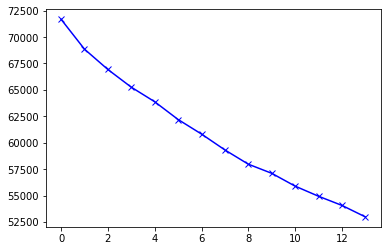

In [ ]:
cost = []
for i in range(1, 15):
  kmean = KMeans(i*20)
  kmean.fit(carts01)
  cost.append(kmean.inertia_)
  print('Готово разбиение на ', i*20, 'классов', sep='')

plt.plot(cost, 'bx-')

In [ ]:
# Разбиение на 280 классов
for clusterNumber in range(max(labels)):                     # пробегаем по всем значениям
  if (clusterSize[clusterNumber] > 5):                       # если размер кластера больше 5
    pos, posVal = getCluster(carts01[labels==clusterNumber]) # получаем позиции и их количество в текущем кластере
    print('Покупок: ', clusterSize[clusterNumber])           # выводим размер текущего кластера
    print('Позиций: ', len(pos))                             # выводим общее число позиций в текущем кластере
    pos = np.array(pos)                                      # преобразуем в numpy
    posVal = np.array(posVal)                               
    indexes = posVal > 0.2                                   # берем индексы тех позиций, доля которых составляет более 20% 
    indexedPos = pos[indexes]                                # выбираем эти позиции из pos
    indexedPosVal = posVal[indexes]                          # выбираем доли этих позиций  

    # Отображаем долю позиции и название самой позиции
    for i in range(len(indexedPos)):
      print(round(100*indexedPosVal[i]), '%', indexedPos[i], sep='')

    print()
    print()


Покупок:  21
Позиций:  151
86%['Услуга - вскрытие посылки']


Покупок:  10
Позиций:  211
30%['10/6 яркий блонд фиолетовый Интенсивное тонирование НОВЫЙ']
30%['10/81 яркий блонд перламутрово-пепельный Интенсивное тонирование НОВЫЙ']
60%['Fiber Infusion восстанавливающее средство 750 мл.']
40%['Fiber Infusion средство с кератином 100 мл.']
60%['Интенсивная маска для поврежденных волос Visible Repair 200 мл. Londa']
70%['Кондиционер для окрашенных волос Color Radiance 1000 мл. Londa']
30%['Кондиционер для окрашенных волос Color Radiance 250 мл. Londa']
40%['Кондиционер для поврежденных волос Visible Repair 1000 мл. Londa']
40%['Кондиционер для поврежденных волос Visible Repair 250 мл. Londa']
40%['Маска для коричневых оттенков волос Color Revive Cool Brown 200 мл.']
40%['Маска для светлых оттенков волос Color Revive Blonde and Silver 200 мл.']
60%['Масло Velvet Oil с аргановым маслом 100 мл. Londa']
50%['Масло Velvet Oil с аргановым маслом 30 мл. Londa']
30%['Несмываемый мусс-кондиционер 

# Гистограммы

In [ ]:
print(max(clusterSize), min(clusterSize)) # посмотрим сколько максимум корзин в кластере и минимум

9988 1


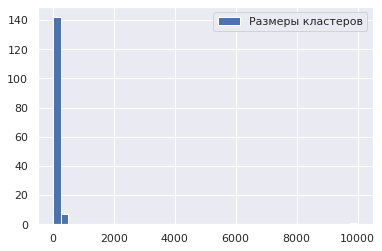

In [ ]:
plt.hist(clusterSize, 40, label="Размеры кластеров")
plt.legend()
plt.show()

In [ ]:
clusterNumber # у нас 148 кластеров

148

In [ ]:
listPosUnique = []
for clusterNumber in range(max(labels)):                     # пробегаем по всем значениям
  if (clusterSize[clusterNumber] > 5):                       # если размер кластера больше 5
    pos, posVal = getCluster(carts01[labels==clusterNumber]) # получаем позиции и их количество в текущем кластере
    print('Покупок: ', clusterSize[clusterNumber])           # выводим размер текущего кластера
    posUnique = len(np.unique(pos))                          # cчитаем уникальные позиции в кластере
    print('Уникальных позиций в кластере : ', posUnique, "из", len(pos))  # выводим число уникальных позиций в текущем кластере
    listPosUnique.append(posUnique)                          # добавляем значение количества уникальных позиций в список
          
    pos = np.array(pos)                                      # преобразуем в numpy
    posVal = np.array(posVal) 
    
                         
    indexes = posVal > 0.2                                   # берем индексы тех позиций, доля которых составляет более 20% 
    indexedPos = pos[indexes]                                # выбираем эти позиции из pos
    indexedPosVal = posVal[indexes]                          # выбираем доли этих позиций  

    # Отображаем долю позиции и название самой позиции
    for i in range(len(indexedPos)):
      print(round(100*indexedPosVal[i]), '%', indexedPos[i], sep='')


Покупок:  21
Уникальных позиций в кластере :  151 из 151
86%['Услуга - вскрытие посылки']
Покупок:  10
Уникальных позиций в кластере :  211 из 211
30%['10/6 яркий блонд фиолетовый Интенсивное тонирование НОВЫЙ']
30%['10/81 яркий блонд перламутрово-пепельный Интенсивное тонирование НОВЫЙ']
60%['Fiber Infusion восстанавливающее средство 750 мл.']
40%['Fiber Infusion средство с кератином 100 мл.']
60%['Интенсивная маска для поврежденных волос Visible Repair 200 мл. Londa']
70%['Кондиционер для окрашенных волос Color Radiance 1000 мл. Londa']
30%['Кондиционер для окрашенных волос Color Radiance 250 мл. Londa']
40%['Кондиционер для поврежденных волос Visible Repair 1000 мл. Londa']
40%['Кондиционер для поврежденных волос Visible Repair 250 мл. Londa']
40%['Маска для коричневых оттенков волос Color Revive Cool Brown 200 мл.']
40%['Маска для светлых оттенков волос Color Revive Blonde and Silver 200 мл.']
60%['Масло Velvet Oil с аргановым маслом 100 мл. Londa']
50%['Масло Velvet Oil с аргановы

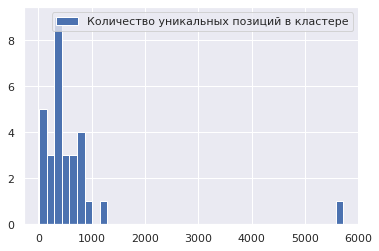

In [ ]:
plt.hist(listPosUnique, 40, label="Количество уникальных позиций в кластере")
plt.legend()
plt.show()

Вывод: При разбиении на 148 кластеров все позиции в кластерах , в которых более 5 корзин, оказались уникальными. Нужно уменьшить количество кластеров, тогда получим значения , которые будут пригодны для задачи рекомендательной системы. 